In [93]:
import pandas as pd
import numpy as np
import torch
from torch import nn, Tensor, optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from math import floor, ceil, log
from typing import Optional, Literal
from dataclasses import dataclass
import matplotlib.pyplot as plt
from enum import Enum
from pathlib import Path
import time
import datetime

from sklearn.preprocessing import StandardScaler

from early_stopping import EarlyStopping


In [3]:
class MVA(nn.Module):
    def __init__(self, q: int):
        super().__init__()
        self.q = q
        self.mva = nn.AvgPool1d(kernel_size=q, stride=1)

    def forward(self, x: Tensor) -> Tensor:
        left_pad = x[:, 0:1].repeat(1, floor((self.q - 1) / 2), 1)
        right_pad = x[:, -1:].repeat(1, ceil((self.q - 1) / 2), 1)
        x_padded = torch.cat((left_pad, x, right_pad), dim=1)
        x_trend = self.mva(x_padded.transpose(-2, -1)).transpose(-2, -1)
        return x_trend


class SeriesDecomp(nn.Module):
    def __init__(self, q: int):
        super().__init__()
        self.mva = MVA(q)

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        trend = self.mva(x)
        seasonal = x - trend
        return seasonal, trend


class LayerNorm(nn.Module):
    def __init__(self, C_out: int):
        super().__init__()
        self.layer_norm = nn.LayerNorm(C_out)

    def forward(
        self,
        x: Tensor,
    ) -> Tensor:
        x_hat = self.layer_norm(x)
        bias = torch.mean(x_hat, dim=1, keepdim=True)
        return x_hat - bias


torch.Size([1, 204, 1])
tensor([[1.6362e-08]]) tensor([[1.0049]])
torch.Size([1, 204, 0])


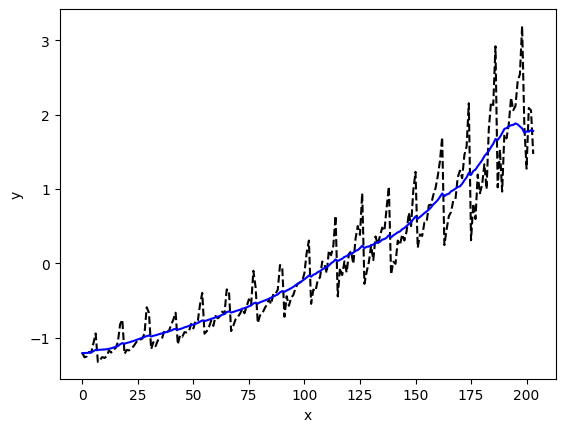

In [39]:
df = pd.read_csv('data/AusAntidiabeticDrug.csv')

PERIODS = ['month', 'day', 'weekday', 'hour', 'minute']
period2ix = {p: i for i, p in enumerate(PERIODS)}

data_x = df[['y']].values.astype(np.float32)

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)

x = torch.as_tensor(data_x).view(1, -1, 1)
print(x.shape)
print(torch.mean(x, dim=1), torch.var(x, dim=1))

x_mark = torch.as_tensor(df[[p for p in PERIODS if p in df.columns]].values).unsqueeze(
    0
)
print(x_mark.shape)

decomp = SeriesDecomp(25)
seasonal, trend = decomp(x)

plt.ylabel('y')
plt.xlabel('x')
plt.plot(torch.arange(x.shape[1]), x[0], 'k--', label='y')
plt.plot(torch.arange(x.shape[1]), trend[0], 'b-', label='y')
plt.show()


In [7]:
class TokenEmbedding(nn.Module):
    def __init__(self, C_in: int, D_model: int):
        super().__init__()

        self.token_conv = nn.Conv1d(
            C_in, D_model, kernel_size=3, padding=1, padding_mode='circular', bias=False
        )

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu'
                )

    def forward(
        self,
        x: Tensor,  # (B, L, C)
    ) -> Tensor:  # (B, L, D)
        x = self.token_conv(x.transpose(-2, -1)).transpose(-2, -1)

        return x


class PositionalEmbedding(nn.Module):
    def __init__(self, D_model: int, L_max: int):
        super().__init__()

        pe = torch.zeros(L_max, D_model)
        pe.requires_grad = False

        position = torch.arange(0, L_max).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, D_model, 2) * -(log(10000.0) / D_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        # Buffers are tensors which do not require gradients
        # and are thus not registered as parameters.
        # They can be loaded inside the state_dict.
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor):
        return self.pe[:, : x.shape[1]]


Frequency = Literal['t', 'h']


class TemporalEmbedding(nn.Module):
    def __init__(self, D_model: int, max_freq: Frequency):
        super().__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        if max_freq == 't':
            self.minute_embd = nn.Embedding(minute_size, D_model)
        self.hour_embd = nn.Embedding(hour_size, D_model)
        self.weekday_embd = nn.Embedding(weekday_size, D_model)
        self.day_embd = nn.Embedding(day_size, D_model)
        self.month_embd = nn.Embedding(month_size, D_model)

    def forward(
        self,
        x_mark: Tensor,  # ?
    ):
        minute_x = (
            self.minute_embd(x_mark[..., period2ix['minute']])
            if hasattr(self, 'minute_embd')
            else 0.0
        )
        hour_x = self.hour_embd(x_mark[..., period2ix['hour']])
        weekday_x = self.weekday_embd(x_mark[..., period2ix['weekday']])
        day_x = self.day_embd(x_mark[..., period2ix['day']])
        month_x = self.month_embd(x_mark[..., period2ix['month']])

        return minute_x + hour_x + weekday_x + day_x + month_x


class DataEmbedding(nn.Module):
    def __init__(
        self,
        C_in: int,
        D_model: int,
        L_max: int,
        embed_positions: bool = True,
        highest_freq: Frequency = 'h',
        dropout: float = 0.1,
    ):
        super().__init__()

        self.token_embd = TokenEmbedding(C_in, D_model)
        self.pos_embd = PositionalEmbedding(D_model, L_max)
        self.temp_embd = TemporalEmbedding(D_model, highest_freq)
        self.dropout = nn.Dropout(dropout)

        self.embed_positions = embed_positions

    def forward(self, x: Tensor, x_mark: Tensor):
        x = self.token_embd(x) + self.temp_embd(x_mark)
        if self.embed_positions:
            x += self.pos_embd(x)
        return self.dropout(x)


In [8]:
tok_embd = TokenEmbedding(1, 64)
pos_embd = PositionalEmbedding(64, 256)
temp_embd = TemporalEmbedding(64, 'h')
data_embd = DataEmbedding(1, 64, 256, embed_positions=True, highest_freq='h')

x_tok = tok_embd(x)
x_pos = pos_embd(x)
x_temp = temp_embd(x_mark)
x_data = data_embd(x, x_mark)

print(x_tok.shape)
print(x_tok.squeeze())
print(x_pos.shape)
print(x_pos.squeeze())
print(x_temp.shape)
print(x_temp.squeeze())
print(x_data.shape)
print(x_data.squeeze())


torch.Size([1, 204, 64])
tensor([[ 1.6085,  1.2902,  2.5168,  ..., -0.5973,  0.0638, -3.4399],
        [-1.1397,  3.3407,  3.6184,  ..., -2.3903, -0.1666, -0.1158],
        [-1.2180,  3.2804,  3.5587,  ..., -2.4262, -0.1361,  0.0325],
        ...,
        [ 1.1556, -4.9447, -5.6871,  ...,  3.4970,  0.1902,  1.0640],
        [ 2.1957, -4.5711, -5.3238,  ...,  4.1370, -0.1378, -0.6831],
        [ 2.9903,  0.1242, -1.5940,  ...,  3.9898, -1.7221, -4.0304]],
       grad_fn=<SqueezeBackward0>)
torch.Size([1, 204, 64])
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
          1.3335e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
          2.6670e-04,  1.0000e+00],
        ...,
        [-6.1890e-02,  9.9808e-01, -6.7666e-02,  ...,  9.9936e-01,
          2.6801e-02,  9.9964e-01],
        [ 8.0642e-01,  5.9135e-01,  6.3048e-01,  ...,  9

In [12]:
BATCH_SIZE = 32
SEQ_LEN = 128
EMBED_DIM = 32
B, L, E = BATCH_SIZE, SEQ_LEN, EMBED_DIM
HEAD_SIZE = EMBED_DIM
TOP_K = 3
dH = HEAD_SIZE

query_projection = nn.Linear(E, dH)
key_projection = nn.Linear(E, dH)
value_projection = nn.Linear(E, dH)

torch.manual_seed(42)
test_x = torch.randn(B, L, E)
queries = query_projection(test_x)  # (B, L, H)
keys = key_projection(test_x)  # (B, L, H)
values = value_projection(test_x)  # (B, L, H)


def autocorrelation_paper():
    q_fft = torch.fft.rfft(queries.transpose(-2, -1).contiguous(), dim=-1)
    k_fft = torch.fft.rfft(keys.transpose(-2, -1).contiguous(), dim=-1)
    s = q_fft * k_fft.conj()
    corr = torch.fft.irfft(s, n=L, dim=-1)  # (B, H, L)
    weights, delays = torch.topk(corr, TOP_K, dim=-1)  # (B, H, k)
    weights = torch.softmax(weights, dim=-1)
    init_index = torch.arange(L).view(1, 1, L).repeat(B, dH, 1)
    tmp_values = values.transpose(-2, -1).repeat(1, 1, 2)  # (B, H, 2L)
    delays_agg = torch.zeros_like(values.transpose(-2, -1))
    for i in range(TOP_K):
        tmp_delay = init_index + delays[..., i].unsqueeze(-1)
        pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
        delays_agg += pattern * weights[..., i].unsqueeze(-1)
    return delays_agg  # (B, H, L)


def autocorrelation_custom():
    q_fft = torch.fft.rfft(queries, dim=1)
    k_fft = torch.fft.rfft(keys, dim=1)
    tmp_corr = q_fft * k_fft.conj()
    corr = torch.fft.irfft(tmp_corr, n=L, dim=1)
    weights, delays = torch.topk(corr, TOP_K, dim=1)  # (B, k, H)
    weights = torch.softmax(weights, dim=1)
    init_index = torch.arange(L).view(1, L, 1).repeat(B, 1, dH)
    # Repeat twice so that elements shifted beyond the 1st position reappear at the end
    tmp_values = values.repeat(1, 2, 1)  # (B, 2L, H)
    delays_agg = torch.zeros_like(values)
    for i in range(TOP_K):
        tmp_delay = init_index + delays[:, i].view(B, 1, dH)
        pattern = torch.gather(tmp_values, dim=1, index=tmp_delay)
        delays_agg += pattern * weights[:, i].view(B, 1, dH)
    return delays_agg  # (B, L, H)


(autocorrelation_paper().transpose(-2, -1)).allclose(
    autocorrelation_custom(), atol=1e-7
)


True

In [14]:
class AutoCorrelation(nn.Module):
    def __init__(self, c: float):
        super().__init__()
        self.c = c

    def forward(
        self,
        queries: Tensor,  # (B, L, nH, dH)
        keys: Tensor,  # (B, L, nH, dH),
        values: Tensor,  # (B, L, nH, dH)
    ) -> tuple[Tensor, Tensor]:  # ?
        q, k, v = queries, keys, values

        B, L, nH, dH = q.shape
        _, S, _, _ = k.shape

        assert B == k.shape[0] == v.shape[0]
        assert S == v.shape[1]
        assert nH == k.shape[2] == v.shape[2]
        assert dH == k.shape[3]

        # Make q, k, v the same length L
        if S < L:
            zeros = torch.zeros((B, L - S, nH, dH))
            k = torch.cat([k, zeros], dim=1)
            v = torch.cat([v, zeros], dim=1)
        else:
            k = k[:, :L]
            v = v[:, :L]

        # Compute attentions (auto-correlations)
        q_fft = torch.fft.rfft(q, dim=1)
        k_fft = torch.fft.rfft(k, dim=1)
        tmp_corr = q_fft * k_fft.conj()
        corr = torch.fft.irfft(tmp_corr, n=L, dim=1)

        top_k = floor(self.c * log(L))

        weights, delays = torch.topk(
            corr, top_k, dim=1
        )  # (B, k, nH, dH), (B, k, nH, dH)
        weights = torch.softmax(weights, dim=1)

        # Repeat the values twice so that elements shifted
        # beyond the 1st position reappear at the end
        tmp_values = v.repeat(1, 2, 1, 1)  # (B, 2L, nH, dH)
        init_index = torch.arange(L).view(1, L, 1, 1).repeat(B, 1, nH, dH)
        v_new = torch.zeros_like(v)

        for i in range(top_k):
            tmp_delay = init_index + delays[:, i].unsqueeze(1)
            pattern = torch.gather(tmp_values, dim=1, index=tmp_delay)
            v_new += pattern * weights[:, i].view(B, 1, nH, dH)

        return v_new, corr


In [16]:
N_HEADS = 1

dQK = E // N_HEADS
dV = E // N_HEADS

q_mva = query_projection(test_x).view(B, L, N_HEADS, dQK)
k = key_projection(test_x).view(B, L, N_HEADS, dQK)
v = value_projection(test_x).view(B, L, N_HEADS, dV)

c = 3.5 / log(L)
ac = AutoCorrelation(c)
v2, attns = ac(q_mva, k, v)
torch.allclose(v2.squeeze(), autocorrelation_custom())


True

In [17]:
class AutoCorrelationLayer(nn.Module):
    def __init__(self, attention: nn.Module, D: int, nH: int):
        super().__init__()

        dQK = D // nH
        dV = D // nH

        self.query_projection = nn.Linear(D, dQK * nH)
        self.key_projection = nn.Linear(D, dQK * nH)
        self.value_projection = nn.Linear(D, dV * nH)
        self.out_projection = nn.Linear(dV * nH, D)

        self.attention = attention

        self.nH = nH

    def forward(
        self,
        queries: Tensor,  # (B, L, D)
        keys: Tensor,  # (B, S, D)
        values: Tensor,  # (B, L, D)
        attn_mask=None,
    ) -> Tensor:
        B, L, D = queries.shape
        _, S, _ = keys.shape
        nH = self.nH

        assert B == keys.shape[0] == values.shape[0]
        assert S == values.shape[1]
        assert D == keys.shape[2] == values.shape[2]

        queries = self.query_projection(queries).view(B, L, nH, -1)
        keys = self.key_projection(keys).view(B, S, nH, -1)
        values = self.value_projection(values).view(B, S, nH, -1)

        out, attn = self.attention(queries, keys, values)
        out = out.view(B, L, -1)
        out = self.out_projection(out)

        return out, attn


In [18]:
Activation = Literal['relu', 'gelu']


class EncoderLayer(nn.Module):
    def __init__(
        self,
        attention: nn.Module,
        D_model: int,
        D_ff: Optional[int] = None,
        q_mva: Optional[int] = 25,
        dropout: Optional[float] = 0.2,
        activation: Optional[Activation] = 'relu',
    ):
        super().__init__()

        D_ff = D_ff or D_model * 4

        self.dropout = nn.Dropout(dropout)
        self.decomp1 = SeriesDecomp(q_mva)
        self.decomp2 = SeriesDecomp(q_mva)
        self.conv1 = nn.Conv1d(D_model, D_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(D_ff, D_model, kernel_size=1, bias=False)
        self.activation = F.relu if activation == 'relu' else F.gelu

        self.attention = attention

    def forward(
        self,
        x: Tensor,  # (B, L, D)
        attn_mask: Optional[Tensor] = None,  # ?
    ) -> tuple[Tensor, Tensor]:  # (B, L, D), ?
        x, attn = self.attention(x, x, x, attn_mask=attn_mask)
        x = x + self.dropout(x)
        x, _ = self.decomp1(x)
        y = self.dropout(self.activation(self.conv1(x.transpose(-2, -1))))
        y = self.dropout(self.conv2(y).transpose(-2, -1))
        x, _ = self.decomp2(x + y)
        return x, attn


class Encoder(nn.Module):
    def __init__(
        self,
        attn_layers: list[nn.Module],
        conv_layers: Optional[list[nn.Module]] = None,
        norm_layer: Optional[nn.Module] = None,
    ):
        super().__init__()

        if conv_layers is not None:
            assert len(conv_layers) < len(attn_layers)

        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = (
            nn.ModuleList(conv_layers) if conv_layers is not None else None
        )
        self.norm_layer = norm_layer

    def forward(
        self,
        x: Tensor,  # (B, L, D)
        attn_mask: Optional[Tensor] = None,  # ?
    ) -> Tensor:
        attns = []
        if self.conv_layers is not None:
            # ? untested
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)
        if self.norm_layer is not None:
            x = self.norm_layer(x)
        return x, attns


In [19]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        self_attention: nn.Module,
        cross_attention: nn.Module,
        D_model: int,
        C_out: int,
        D_ff: Optional[int] = None,
        q_mva: Optional[int] = 25,
        dropout: Optional[float] = 0.1,
        activation: Optional[Activation] = 'relu',
    ):
        super().__init__()

        D_ff = D_ff or 4 * D_model

        self.conv1 = nn.Conv1d(D_model, D_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(D_ff, D_model, kernel_size=1, bias=False)
        self.decomp1 = SeriesDecomp(q_mva)
        self.decomp2 = SeriesDecomp(q_mva)
        self.decomp3 = SeriesDecomp(q_mva)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Conv1d(
            D_model,
            C_out,
            kernel_size=3,
            padding=1,
            padding_mode='circular',
            bias=False,
        )
        self.activation = F.relu if activation == 'relu' else F.gelu

        self.self_attention = self_attention
        self.cross_attention = cross_attention

    def forward(
        self,
        x: Tensor,  # (B, L, D)
        cross: Tensor,  # (B, L, D),
        x_mask: Optional[Tensor] = None,  # ?
        cross_mask: Optional[Tensor] = None,  # ?
    ) -> tuple[Tensor, Tensor]:  # (B, L, D), (B, L, D)
        x0 = x
        x, _ = self.self_attention(x, x, x, attn_mask=x_mask)
        x = x0 + self.dropout(x)
        x, t1 = self.decomp1(x)

        x0 = x
        x, _ = self.cross_attention(x, cross, cross, attn_mask=cross_mask)
        x = x0 + self.dropout(x)
        x, t2 = self.decomp2(x)

        x0 = x
        x = self.dropout(self.conv1(x.transpose(-2, -1)))
        x = self.dropout(self.conv2(x).transpose(-2, -1))
        x, t3 = self.decomp3(x0 + x)

        residual_trend = t1 + t2 + t3
        residual_trend = self.projection(residual_trend.transpose(-2, -1)).transpose(
            -2, -1
        )
        return x, residual_trend


class Decoder(nn.Module):
    def __init__(
        self,
        layers: list[DecoderLayer],
        norm_layer: Optional[nn.Module] = None,
        projection=None,
    ):
        super().__init__()

        self.layers = nn.ModuleList(layers)
        self.norm_layer = norm_layer
        self.projection = projection

    def forward(
        self,
        x: Tensor,  # (B, L, D)
        cross: Tensor,  # (B, L, D)
        x_mask: Optional[Tensor] = None,
        cross_mask: Optional[Tensor] = None,
        trend: Optional[Tensor] = None,
    ) -> tuple[Tensor, Tensor]:
        for layer in self.layers:
            x, residual_trend = layer(x, cross, x_mask, cross_mask)
            trend = trend + residual_trend

        if self.norm_layer is not None:
            x = self.norm_layer(x)

        if self.projection is not None:
            x = self.projection(x)

        return x, trend


In [20]:
@dataclass
class AutoformerConfig:
    D_model: int  # feature dimension
    D_ff: int  # inner-feature dimension for FFNNs of encoder and decoder
    c_autocorrelation: float  # coefficient for auto-correlation, recall that k = floor(c * log L)
    num_heads: int
    q_mva: int  # window size for moving average in series decomposition
    dropout: float  # dropout probability
    activation: Activation  # activation function for FFNNs of encoder and decoder
    num_encoder_layers: int
    num_decoder_layers: int
    enc_in: int  # feature dimension of encoder
    dec_in: int  # feature dimension of decoder
    L_max: int  # maximum sequence length, used for positional encoding
    D_out: int  # output dimension
    len_seq: int  # sequence length
    len_pred: int  # the last len_pred points are predicted
    len_label: int  # the last len_label points are unseen


class Autoformer(nn.Module):
    def __init__(self, conf: AutoformerConfig):
        super().__init__()

        self.decomp = SeriesDecomp(conf.q_mva)

        self.enc_embedding = DataEmbedding(
            conf.enc_in,
            conf.D_model,
            conf.L_max,
            embed_positions=False,
            highest_freq='h',
            dropout=conf.dropout,
        )
        self.dec_embedding = DataEmbedding(
            conf.dec_in,
            conf.D_model,
            conf.L_max,
            embed_positions=False,
            highest_freq='h',
            dropout=conf.dropout,
        )

        self.encoder = Encoder(
            attn_layers=[
                EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(conf.c_autocorrelation),
                        conf.D_model,
                        conf.num_heads,
                    ),
                    conf.D_model,
                    conf.D_ff,
                    conf.q_mva,
                    conf.dropout,
                    conf.activation,
                )
                for _ in range(conf.num_encoder_layers)
            ],
            norm_layer=LayerNorm(conf.D_model),
        )

        self.decoder = Decoder(
            layers=[
                DecoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(conf.c_autocorrelation),
                        conf.D_model,
                        conf.num_heads,
                    ),
                    AutoCorrelationLayer(
                        AutoCorrelation(conf.c_autocorrelation),
                        conf.D_model,
                        conf.num_heads,
                    ),
                    conf.D_model,
                    conf.D_out,
                    conf.D_ff,
                    conf.q_mva,
                    conf.dropout,
                    conf.activation,
                )
                for _ in range(conf.num_decoder_layers)
            ],
            norm_layer=LayerNorm(conf.D_model),
            projection=nn.Linear(conf.D_model, conf.D_out),
        )

        self.len_pred = conf.len_pred
        self.len_label = conf.len_label

    def forward(
        self,
        x_enc: Tensor,
        x_mark_enc: Tensor,
        x_dec: Tensor,
        x_mark_dec: Tensor,
        enc_self_mask: Optional[Tensor] = None,
        dec_self_mask: Optional[Tensor] = None,
    ) -> tuple[Tensor, list[Tensor]]:
        # run encoder
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, enc_attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        mean = torch.mean(x_enc, dim=1, keepdim=True).repeat(1, self.len_pred, 1)
        zeros = torch.zeros_like(mean)
        seasonal_init, trend_init = self.decomp(x_enc)

        # decoder input
        trend_init = torch.cat([trend_init[:, -self.len_label :], mean], dim=1)
        seasonal_init = torch.cat([seasonal_init[:, -self.len_label :], zeros], dim=1)

        # run decoder
        dec_in = self.dec_embedding(seasonal_init, x_mark_dec)
        seasonal_part, trend_part = self.decoder.forward(
            dec_in,
            enc_out,
            x_mask=dec_self_mask,
            cross_mask=enc_self_mask,
            trend=trend_init,
        )

        # final
        dec_out = trend_part + seasonal_part

        return dec_out[:, -self.len_pred :, :], enc_attns


In [30]:
cfg = AutoformerConfig(
    D_model=512,
    D_ff=2048,
    c_autocorrelation=1,
    num_heads=8,
    q_mva=25,
    dropout=0.05,
    activation='gelu',
    num_encoder_layers=2,
    num_decoder_layers=1,
    enc_in=1,
    dec_in=1,
    L_max=1000,
    len_pred=96,
    len_label=48,
    len_seq=96,
    D_out=1,
)
model = Autoformer(cfg)
s_begin = 0
s_end = s_begin + cfg.len_seq
r_begin = s_end - cfg.len_label
r_end = r_begin + cfg.len_label + cfg.len_pred

slice_x = slice(s_begin, s_end)
slice_y = slice(r_begin, r_end)
seq_x = x[:, slice_x]
seq_y = x[:, slice_y]
seq_x_mark = x_mark[:, slice_x]
seq_y_mark = x_mark[:, slice_y]

y_pred, _ = model(seq_x, seq_x_mark, seq_y, seq_y_mark)
y_pred[:, 10, :]


torch.Size([1, 96, 1])

In [71]:
class Task(str, Enum):
    multi_predict_multi = 'M'
    uni_predict_uni = 'S'
    multi_predict_uni = 'MS'


class Dataset_ETTSmall(Dataset):
    def __init__(
        self,
        root_path: str = 'data/ETDataset/ETT-small/',
        data_path: str = 'ETTh1.csv',
        sizes: tuple[int, int, int] = (
            24 * 4,
            24 * 2,
            24,
        ),  # (len_seq, len_label, len_pred)
        scale: bool = True,
        task: Task = Task.multi_predict_uni,
    ):
        super().__init__()

        TARGET = 'OT'  # if task is S or MS
        DATE_COLUMNS = ['month', 'day', 'weekday', 'hour']

        data_path = Path(root_path) / data_path

        # decompose date into month, day, weekday, hour
        df_raw = pd.read_csv(data_path)
        df = df_raw.copy()
        df.loc[:, 'dt'] = pd.to_datetime(df['date'])
        dt = df['dt'].dt
        df.loc[:, 'month'] = dt.month
        df.loc[:, 'day'] = dt.day
        df.loc[:, 'weekday'] = dt.weekday
        df.loc[:, 'hour'] = dt.hour
        df.drop(columns=['date', 'dt'], inplace=True)

        # split df into df_x and df_x_mark
        if task in {Task.multi_predict_uni, Task.multi_predict_multi}:
            df_x = df.drop(columns=DATE_COLUMNS)
        elif task in {Task.uni_predict_uni}:
            df_x = df[[TARGET]]
        else:
            raise ValueError(f'Unrecognized task: {task}')

        data_x = df_x.values.astype(np.float32)
        df_x_mark = df[DATE_COLUMNS]
        data_x_mark = df_x_mark.values

        if scale:
            # scale data_x to have zero mean and unit variance
            scaler = StandardScaler()
            scaler.fit(data_x)
            data_x = scaler.transform(data_x)

        self.data_x = data_x
        self.data_x_mark = data_x_mark
        self.len_seq, self.len_label, self.len_pred = sizes

    def __getitem__(self, index: int):
        s_begin = index
        s_end = s_begin + self.len_seq
        r_begin = s_end - self.len_label
        r_end = r_begin + self.len_label + self.len_pred

        seq_x = self.data_x[s_begin:s_end]
        seq_x_mark = self.data_x_mark[s_begin:s_end]
        seq_y = self.data_x[r_begin:r_end]
        seq_y_mark = self.data_x_mark[r_begin:r_end]

        return seq_x, seq_x_mark, seq_y, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.len_seq - self.len_pred + 1


In [84]:
cfg = AutoformerConfig(
    D_model=512,
    D_ff=2048,
    c_autocorrelation=1,
    num_heads=8,
    q_mva=25,
    dropout=0.05,
    activation='gelu',
    num_encoder_layers=2,
    num_decoder_layers=1,
    enc_in=7,
    dec_in=7,
    L_max=10_000,
    D_out=7,
    len_seq=24 * 4,
    len_label=24 * 2,
    len_pred=24,
)

ett_dataset = Dataset_ETTSmall(
    sizes=(cfg.len_seq, cfg.len_label, cfg.len_pred), task=Task.multi_predict_multi
)

pct_train = 0.8

train_size = int(pct_train * len(ett_dataset))
test_size = len(ett_dataset) - train_size

train, test = random_split(ett_dataset, [train_size, test_size])
train_loader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)


In [106]:
FORCE_STOP_AFTER_NUM_BATCHES_TRAIN: Optional[int] = 100
FORCE_STOP_AFTER_NUM_BATCHES_EVAL: Optional[int] = 10

def predict(
    model: nn.Module,
    batch_x: Tensor,  # (B, len_seq+len_label, C)
    batch_x_mark: Tensor,  # (B, len_seq+len_label, P)
    batch_y: Tensor,  # (B, len_label+len_pred, C')
    batch_y_mark: Tensor,  # (B, len_label+len_pred, P)
    len_label: int,
    len_pred: int,
    # If task is S or MS, target is the index of the target variable.
    # If task is M, target should be None. Note that if task is S: target = 0.
    target: Optional[int] = None, 
) -> tuple[Tensor, Tensor]:
    B, len_x, C = batch_x.shape
    _, len_y, _ = batch_y.shape
    _, _, P = batch_x_mark.shape

    assert B == batch_y.shape[0] == batch_x_mark.shape[0] == batch_y_mark.shape[0]
    assert len_x == batch_x_mark.shape[1]
    assert len_y == batch_y_mark.shape[1] == len_label+len_pred
    assert P == batch_y_mark.shape[2]
    
    if target is not None:
        assert 0 <= target < batch_y.shape[2]

    zeros = torch.zeros((B, len_pred, C))
    dec_in = torch.cat(
        [batch_y[:, :len_label, :], zeros], dim=1
    )  # (B, len_label + len_pred, C)

    batch_y_pred, _ = model(batch_x, batch_x_mark, dec_in, batch_y_mark)
    target_slice = slice(None) if target is None else target
    batch_y_pred = batch_y_pred[:, -len_pred:, target_slice]  # (B, len_pred, C')
    batch_y_true = batch_y[:, len_label:, target_slice] # (B, len_pred, C')

    return batch_y_pred, batch_y_true


@torch.no_grad()
def eval(
    test_loader: DataLoader, model: nn.Module, criterion: nn.Module, len_label: int, len_pred: int, target: Optional[int] = None
) -> float:
    model.eval()

    losses = []

    for i, (batch_x, batch_x_mark, batch_y, batch_y_mark) in enumerate(test_loader):
        batch_y_pred, batch_y_true = predict(
            model, batch_x, batch_x_mark, batch_y, batch_y_mark, len_label, len_pred, target
        )
        batch_y_pred = batch_y_pred.detach()
        batch_y_true = batch_y_true.detach()
        loss = criterion(batch_y_pred, batch_y_true)
        losses.append(loss.item())
        
        if FORCE_STOP_AFTER_NUM_BATCHES_EVAL is not None and (i + 1) >= FORCE_STOP_AFTER_NUM_BATCHES_EVAL:
            print('force stopping')
            break

    loss_avg = np.mean(losses)

    model.train()

    return loss_avg


In [107]:
CHECKPOINTS_DIR = 'checkpoints'
LEARNING_RATE = 1e-4
PATIENCE = 3
DELTA = 0.0
TRAIN_EPOCHS = 10
PRINT_EVERY_NUM_BATCHES = 5

checkpoints_path = Path(CHECKPOINTS_DIR)
if not checkpoints_path.exists():
    checkpoints_path.mkdir()

model = Autoformer(cfg)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# TODO: learning rate scheduler

early_stopping = EarlyStopping(
    model, optimizer, CHECKPOINTS_DIR, PATIENCE, DELTA, verbose=True
)

time_before = time.time()

len_train_loader = len(train_loader)
assert len_train_loader > 0

force_stopping = False

for epoch in range(TRAIN_EPOCHS):
    train_losses = []
    iter_count = 0

    epoch_time = time.time()

    for i, (batch_x, batch_x_mark, batch_y, batch_y_mark) in enumerate(
        train_loader
    ):
        iter_count += 1

        optimizer.zero_grad()

        batch_y_pred, batch_y_true = predict(
            model, batch_x, batch_x_mark, batch_y, batch_y_mark, cfg.len_label, cfg.len_pred, target=None
        )

        loss = criterion(batch_y_pred, batch_y_true)
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if (i + 1) % PRINT_EVERY_NUM_BATCHES == 0:
            print(f'batches: {i + 1} | epoch: {epoch + 1} | loss: {loss.item():.4f}')

            speed = (time.time() - time_before) / iter_count
            epochs_left = TRAIN_EPOCHS - epoch
            time_left = speed * (epochs_left * len_train_loader - i)

            print(f'speed: {speed:.4f} s/batch | time left: {datetime.timedelta(seconds=time_left)} s')

            iter_count = 0
            time_before = time.time()
            
        if FORCE_STOP_AFTER_NUM_BATCHES_TRAIN is not None and (i + 1) >= FORCE_STOP_AFTER_NUM_BATCHES_TRAIN:
            print('force stopping')
            force_stopping = True
            break

    train_loss_avg = np.mean(train_losses)
    test_loss_avg = eval(test_loader, model, criterion, cfg.len_label, cfg.len_pred, target=None)

    time_elapsed = time.time() - epoch_time
    print(
        f'epoch: {epoch + 1} | took: {time_elapsed} s | train loss: {train_loss_avg:.4f} | test loss {test_loss_avg:.4f}'
    )

    if early_stopping(epoch, test_loss_avg):
        print('early stopping')
        break
    
    if force_stopping:
        break

# use the best model, not just the last one
best_model_path = checkpoints_path / 'checkpoint.pt'
model.load_state_dict(torch.load(best_model_path)['model_state_dict'])


batches: 5 | epoch: 1 | loss: 1.2563
speed: 2.5759 s/batch | time left: 3:05:17.712539 s
batches: 10 | epoch: 1 | loss: 0.9435
speed: 2.3118 s/batch | time left: 2:46:06.122533 s
batches: 15 | epoch: 1 | loss: 0.9332
speed: 2.4020 s/batch | time left: 2:52:23.117324 s
batches: 20 | epoch: 1 | loss: 0.6207
speed: 2.3347 s/batch | time left: 2:47:21.408984 s
batches: 25 | epoch: 1 | loss: 0.6595
speed: 2.3004 s/batch | time left: 2:44:42.365253 s
batches: 30 | epoch: 1 | loss: 0.6350
speed: 2.3602 s/batch | time left: 2:48:47.802860 s
batches: 35 | epoch: 1 | loss: 0.5184
speed: 2.2844 s/batch | time left: 2:43:10.762785 s
batches: 40 | epoch: 1 | loss: 0.4690
speed: 2.2947 s/batch | time left: 2:43:43.436993 s
batches: 45 | epoch: 1 | loss: 0.4905
speed: 2.3114 s/batch | time left: 2:44:43.564888 s
batches: 50 | epoch: 1 | loss: 0.4118
speed: 2.5258 s/batch | time left: 2:59:47.697051 s
batches: 55 | epoch: 1 | loss: 0.4715
speed: 2.5036 s/batch | time left: 2:58:00.453721 s
batches: 60

<All keys matched successfully>

C:\Users\bensa\AppData\Local\Temp\ipykernel_41892\483250772.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


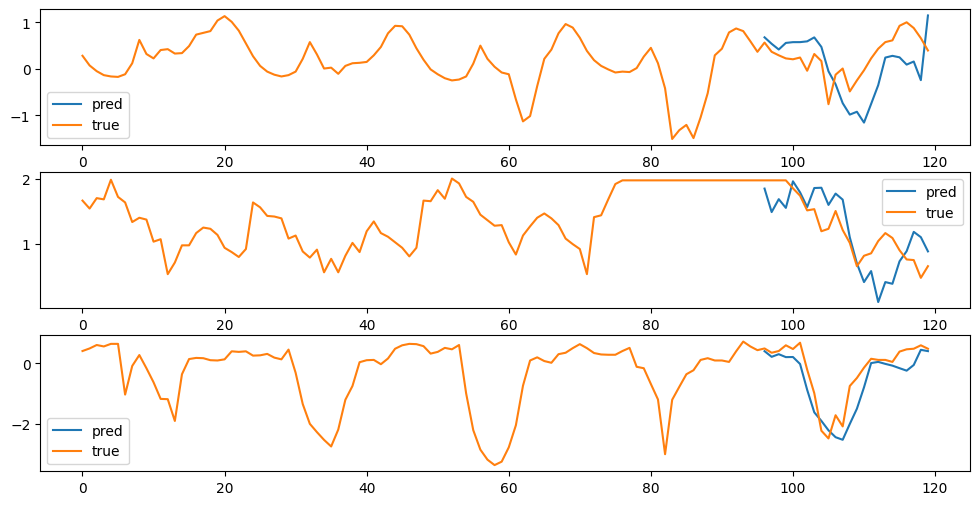

In [125]:
TARGET = 0

model.eval()

with torch.no_grad():
    batch_x, batch_x_mark, batch_y, batch_y_mark = next(iter(train_loader))
    batch_y_pred, batch_y_true = predict(
        model, batch_x, batch_x_mark, batch_y, batch_y_mark, cfg.len_label, cfg.len_pred, target=None
    )
    batch_y_pred = batch_y_pred.detach().numpy()
    batch_y_true = batch_y_true.detach().numpy()

    idx = np.random.randint(0, len(batch_y_pred), size=3)
    y_pred = batch_y_pred[idx, :, TARGET]
    y_true = np.concatenate((batch_x[idx, :, TARGET], batch_y_true[idx, :, TARGET]), axis=1)
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 6))
    true_range = range(cfg.len_seq + cfg.len_pred)
    pred_range = range(cfg.len_seq, cfg.len_seq + cfg.len_pred)
    for i in range(3):
        ax[i].plot(pred_range, y_pred[i], label='pred')
        ax[i].plot(true_range, y_true[i], label='true')
        ax[i].legend()
    fig.show()

model.train();